# Nonlinear time-dependent PDEs in FEniCS

We can consider the **time-dependent heat equation** with a forcing term $f(u)$ that is **nonlinear** in the unknown $u$. The equations read as follows:

$$
\frac{\partial u}{\partial t} + u_{xx} = f(u)  \qquad \text{ for } x \in \Omega \text{ and for } t \in [0, T], \\
u = g  \qquad \text{ for } x \in \partial \Omega \text{ and } t \in [0, T], \\
u = u^0 \qquad \text{ for } x \in \Omega \text{ and } t = 0.
$$


$\Omega$ denotes the spatial domain and $\partial \Omega$ the domain boundary. For example for $\Omega = [-L, L]$, the boundary $\partial \Omega$ consists of the two points $-L$ and $L$. We start the simulation at time $t=0$ until the final time $T$.

The solution $u = u(x, t)$, the right-hand side $f = f (u(x, t))$ can be any nonlinear expression function of $u,$ and the boundary value $g = g(x, t)$ may vary in space $(x)$ and time (t). The initial value $u_0$ is a function of space only.


# Newton's method can be used to linearize and solve the equation

At each time step we have the semidiscretized equation to solve:

$$F(x) = u^n − \Delta t u^n_{xx} - u^{n-1} - \Delta t f^n = 0,$$
for $n=1,\dots, N.$

Since $f(u)$ is a non linear expression of $u$ we need to define a method to linearize the equation. For example, we can use the **Newton's method**.

In [1]:
from IPython.display import HTML
HTML('<a title="By Ralf Pfeifer (de:Image:NewtonIteration Ani.gif) [GFDL (http://www.gnu.org/copyleft/fdl.html) or CC-BY-SA-3.0 (http://creativecommons.org/licenses/by-sa/3.0/)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File%3ANewtonIteration_Ani.gif"><img width="512" alt="NewtonIteration Ani" src="https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif"/></a>')

## Some implementation tips

If you use FEniCS you do not need to implement a Newton's scheme since it is already implemented!

Anyway, there are few differences compared to the linear case in the syntax.

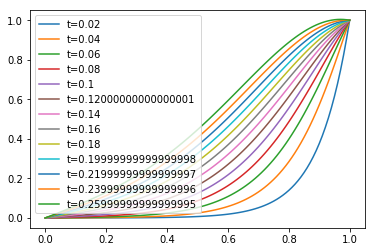

In [1]:
%matplotlib inline
from fenics import *
import pylab
#parameters['plotting_backend'] = 'matplotlib'

def f(u):
    return u*u

mesh = UnitIntervalMesh(100)
V = FunctionSpace(mesh, "CG", 1)
u = Function(V)
u0 = Function(V)
v = TestFunction(V)
bc = [DirichletBC(V, 0.0, "x[0]==0.0 && on_boundary"),
      DirichletBC(V, 1.0, "x[0]==1.0 && on_boundary")]

D = Constant(0.1)
dt = 0.1
a = u/dt*v*dx + D*inner(grad(u), grad(v))*dx
L = u0/dt*v*dx + f(u)*v*dx

F = a-L

t = 0
T = 0.25
dt = 0.02
n_timesteps = 0
while t<=T:
    t +=dt
    n_timesteps += 1
    solve(F==0, u, bc)
    u0.assign(u)
        
    if n_timesteps % 1 == 0:
        plot(u, label="t={}".format(t))
        
pylab.legend()

In this case, we do not define a Trial Function but only a Function. Both the left and the right hand side change at every timestep. Therefore, it is not possible to assemble the matrix before the time loop unlike the linear case. In addition, the form needs to be written such that everything is on the left hand side (F==0) 

## FEniCS challenge 
Solve the cubic, bistable cable equation on an interval $\Omega=[-L, L]$ in FEniCS 
$$
\frac{\partial u}{\partial t} = \sigma u_{xx} + f(u) \quad \text{ for } -L < x < L, \\
u_x = 0 \quad \text{ for } x = -L \text{ and } x = L,
$$
with 
* $f(u) = Au(1-u)(u-\alpha)$,
* $\alpha = 0.1$,
* $A = 1.0$.
* $\sigma = 1.0$,
* $L = 100$.

Implement an implicit Euler time-stepping scheme and solve the problem from $t=0$ to $T=250$ with a timestep of $dt=2.5$. Use as initial condition

$$
\frac{1}{2} (\text{exp} (-x^2) - \text{exp} (-(x-L)^2)
$$

Note that the initial conditions look like two bumps - one positive at $x=0$, one negative at $x=L$. What do you think will happen to them as $t$ increases?

## FEniCS challenge solution

See below. Note that I have used $\sigma=0.1$ instead of $\sigma=1.0$. It is interesting to vary this and see how it affects whether the initial bump causes a propagating potential or not. Varying $\alpha$ is also interesting - what effect do you think this will have?

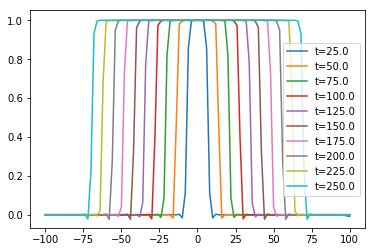

In [4]:
#%matplotlib inline
from fenics import *
import pylab
#parameters['plotting_backend'] = 'matplotlib'
A = Constant(1)
alpha = Constant(0.1)

t = 0
T = 250
dt = 2.5
n_timesteps = 0

def f(u):
    return A*u*(1-u)*(u-alpha)

mesh = IntervalMesh(100, -100, 100)
V = FunctionSpace(mesh, "CG", 1)
u = Function(V)
u0 = interpolate(Expression("0.5*exp(-pow(x[0], 2)) - 0.5*exp(-pow(x[0] - L, 2))", L=100, degree=3), V) #Function(V)
v = TestFunction(V)

sigma = Constant(0.1)


a = u/dt*v*dx + sigma*inner(grad(u), grad(v))*dx
L = u0/dt*v*dx + f(u)*v*dx

F = a-L

solutions = []
while t<=T:
    t +=dt
    n_timesteps += 1
    solve(F==0, u)
    u0.assign(u)
    solutions.append((t, u0.copy())) 
        
    if n_timesteps % 10 == 0:
        plot(u, label="t={}".format(t))
        
pylab.legend()

In [5]:
%matplotlib inline
from ipywidgets import interact, IntSlider


### the below then gives you a movable slider which you can drag around  to see the solution at different times

def plot_solution(n):
    t, U = solutions[n]
    p = plot(U, title="potential (t = {})".format(t))
    p[0].axes.set_ylim([-1, 1.2])

slider = IntSlider(min=0, max=len(solutions)-1, continuous_update=False)
slider.layout.width = "80%"

interact(plot_solution,n=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n', layout=Layout(width='80%'))…

<function __main__.plot_solution(n)>